# Energy - compare different firmwares

Study the impact of different M3 images on energy consumption.

Generate 2 load profiles (low and high) to compare the energy consumption of firmwares (contikimac, tsch and nullrdc).

In [1]:
import os
cur_dir=os.getcwd() # save current directory to save the generated CSV files

%cd ../../..
%pwd

/home/jovyan/work


'/home/jovyan/work'

## Introduction

This notebook uses the 03-g5k-iotlab.ipynb to evaluate the impact of firmware images.

It is divided in 3 main parts, which could be 3 different notebooks depending on the complexity of your study. For the hackathon, however, we opt for keeping them in the same notebook.

- **Description**: creates a data frame containing the description of the different parameters of your experiment.
- **Running**: Reads the data frame with the description the experiment and runs each experiment. It uses papermill to call the 03-g5k-iotlab.ipynb notebook with the correct parameters. Also, creates a data frame with the results.
- **Analysis**: Finally, read the output from the running phase and performs the data analysis.

Note that you can run each part **independently**. It only depends on running the first cell of this notebook to set the cur_dir properly.

## Description

Detailing the parameters used in the different experiment runs.

In [2]:
import pandas
import io
import uuid
import datetime

experiments=io.StringIO("""
firmware,iotlab_nodes,g5k_nodes,duration,sleep_interval
contikimac,4,1,300,0.1
contikimac,4,1,300,5
tsch,4,1,300,0.1
tsch,4,1,300,5
nullrdc,4,1,300,0.1
nullrdc,4,1,300,5
""")

job_name="rsd-hackathon"

df = pandas.read_csv(experiments)

df['exp_id'] = [str(uuid.uuid4()) for _,_ in df.iterrows()]
df['date'] = str(datetime.date.today())
df['data_dir'] = ["data/raw/%s/%s" % (i['date'], i['exp_id']) for _,i in df.iterrows()]
df['notebook_dir'] = ["%s/%s" % (cur_dir, i['exp_id']) for _,i in df.iterrows()]
df['state'] = 'created'

df = df.sample(frac=1).reset_index(drop=True) # randomize test execution
df.to_csv("%s/experiment.csv" % cur_dir)

df

firmware  iotlab_nodes  g5k_nodes  duration  sleep_interval  \
0        tsch             4          1       300             0.1   
1     nullrdc             4          1       300             5.0   
2  contikimac             4          1       300             5.0   
3     nullrdc             4          1       300             0.1   
4        tsch             4          1       300             5.0   
5  contikimac             4          1       300             0.1   

                                 exp_id        date  \
0  fe58d6fe-7a62-4424-ba3f-ed16aae2fac3  2021-09-07   
1  2daaf00a-8fc7-4b09-9c82-e1e909c4fa9f  2021-09-07   
2  2b9a9886-8ed4-41f4-a9c7-55732432c2c9  2021-09-07   
3  028df5f7-5f5b-44bf-9c4f-ae7288782bdb  2021-09-07   
4  176b677b-5e0c-4cbb-ad13-952538e7a52f  2021-09-07   
5  c026cf79-c26c-44d1-ac38-75d715b8634f  2021-09-07   

                                            data_dir  \
0  data/raw/2021-09-07/fe58d6fe-7a62-4424-ba3f-ed...   
1  data/raw/2021-09-07/2daaf00a-8fc7-4b09-9c82-e1...   
2  data/raw/2021-09-07/2b9a9886-8ed4-41f4-a9c7-55...   
3  data/raw/2021-09-07/028df5f7-5f5b-44bf-9c4f-ae...   
4  data/raw/2021-09-07/176b677b-5e0c-4cbb-ad13-95...   
5  data/raw/2021-09-07/c026cf79-c26c-44d1-ac38-75...   

                                        notebook_dir    state  
0  /home/jovyan/analysis/07-energy/2021-09-06-ene...  created  
1  /home/jovyan/analysis/07-energy/2021-09-06-ene...  created  
2  /home/jovyan/analysis/07-energy/2021-09-06-ene...  created  
3  /home/jovyan/analysis/07-energy/2021-09-06-ene...  created  
4  /home/jovyan/analysis/07-energy/2021-09-06-ene...  created  
5  /home/jovyan/analysis/07-energy/2021-09-06-ene...  created

## Running

In [3]:
import papermill as pm
import pathlib

# read the description of the experiment
df = pandas.read_csv("%s/experiment.csv" % cur_dir)
for index, exp in df.iterrows():
    if exp['state'] != 'created':
        continue

    print("Running experiment number: %d, ID: %s, firmware: %s, sleep_interval %f" % (index, exp['exp_id'], exp['firmware'], exp['sleep_interval']))
    pathlib.Path(exp['notebook_dir']).mkdir(exist_ok=True, parents=True)

    pm.execute_notebook(
        'analysis/03-grid5000/03-g5k-iotlab.ipynb',
        '%s/07-energy-%s-%f-%s.ipynb' % (exp['notebook_dir'], exp['firmware'], exp['sleep_interval'], exp['exp_id']),
        cwd = "analysis/03-grid5000/",  # going back to folder to execute notebook
        parameters = dict(
            output_dir = exp['data_dir'],
            er_image = "data/firmware/%s/er-example-server.iotlab-m3" % exp['firmware'],
            br_image = "data/firmware/%s/border-router.iotlab-m3" % exp['firmware'],
            free_resources = False if index < len(df.index) - 1 else True, #free resources in last experiment
            duration = exp['duration'],
            sleep_interval = exp['sleep_interval'],
            iotlab_nodes = exp['iotlab_nodes'],
            iotlab_site = 'grenoble',
            g5k_nodes = exp['g5k_nodes'],
        )
    )
    # change and save new state
    df.at[index, 'state'] = 'executed'
    df.to_csv("%s/experiment.csv" % cur_dir)


Running experiment number: 0, ID: fe58d6fe-7a62-4424-ba3f-ed16aae2fac3, firmware: tsch, sleep_interval 0.100000


Executing:   0%|          | 0/68 [00:00<?, ?cell/s]

Running experiment number: 1, ID: 2daaf00a-8fc7-4b09-9c82-e1e909c4fa9f, firmware: nullrdc, sleep_interval 5.000000


Executing:   0%|          | 0/68 [00:00<?, ?cell/s]

Running experiment number: 2, ID: 2b9a9886-8ed4-41f4-a9c7-55732432c2c9, firmware: contikimac, sleep_interval 5.000000


Executing:   0%|          | 0/68 [00:00<?, ?cell/s]

Running experiment number: 3, ID: 028df5f7-5f5b-44bf-9c4f-ae7288782bdb, firmware: nullrdc, sleep_interval 0.100000


Executing:   0%|          | 0/68 [00:00<?, ?cell/s]

Running experiment number: 4, ID: 176b677b-5e0c-4cbb-ad13-952538e7a52f, firmware: tsch, sleep_interval 5.000000


Executing:   0%|          | 0/68 [00:00<?, ?cell/s]

Running experiment number: 5, ID: c026cf79-c26c-44d1-ac38-75d715b8634f, firmware: contikimac, sleep_interval 0.100000


Executing:   0%|          | 0/68 [00:00<?, ?cell/s]

Parse and salve results.

In [4]:
import pandas

#where to save the results from experiment, open file if it already exists
out_elapsed = None
out_energy = None
elapsed_filename = "%s/elapsed_results.csv" % cur_dir
energy_filename = "%s/energy_results.csv" % cur_dir

# read the description of the experiment
df = pandas.read_csv("%s/experiment.csv" % cur_dir)
for index, exp in df.iterrows():
    if exp['state'] != 'executed':
        continue

    # read and save output of this test
    elapsed = pandas.read_csv(exp['data_dir'] + "/elapsed_time.csv")
    elapsed['exp_id'] = exp['exp_id']
    elapsed['sleep_interval'] = exp['sleep_interval']
    elapsed['firmware'] = exp['firmware']
    out_elapsed = pandas.concat([out_elapsed, elapsed])
    out_elapsed.to_csv(elapsed_filename)
    
    energy = pandas.read_csv(exp['data_dir'] + "/energy.csv")
    energy['exp_id'] = exp['exp_id']
    energy['sleep_interval'] = exp['sleep_interval']
    energy['firmware'] = exp['firmware']
    out_energy = pandas.concat([out_energy, energy])
    out_energy.to_csv(energy_filename)


## Analysis

### Energy

Read the dataframe with the results of all experiments

In [2]:
%load_ext rpy2.ipython
import pandas

out = pandas.read_csv("%s/energy_results.csv" % cur_dir)
out

Unnamed: 0  Unnamed: 0.1     timestamp         type    num         t_s  \
0               0             0  1.631004e+09  consumption      1  1631004235   
1               1             1  1.631004e+09  consumption      2  1631004235   
2               2             2  1.631004e+09  consumption      3  1631004235   
3               3             3  1.631004e+09  consumption      4  1631004235   
4               4             4  1.631004e+09  consumption      5  1631004235   
...           ...           ...           ...          ...    ...         ...   
80663       13611         32735  1.631006e+09  consumption  32736  1631006388   
80664       13612         32736  1.631006e+09  consumption  32737  1631006388   
80665       13613         32737  1.631006e+09  consumption  32738  1631006388   
80666       13614         32738  1.631006e+09  consumption  32739  1631006388   
80667       13615         32739  1.631006e+09  consumption  32740  1631006388   

         t_us     power  voltage   current   node  \
0      665226  0.050931  3.26250  0.015609  m3_16   
1      731044  0.050809  3.26250  0.015604  m3_16   
2      796863  0.050809  3.26250  0.015599  m3_16   
3      862651  0.050809  3.26250  0.015599  m3_16   
4      928470  0.050809  3.26250  0.015599  m3_16   
...       ...       ...      ...       ...    ...   
80663  568669  0.168794  3.27375  0.051566  m3_18   
80664  634457  0.170992  3.27625  0.052187  m3_18   
80665  700215  0.177221  3.27375  0.054126  m3_18   
80666  765973  0.168916  3.27500  0.051581  m3_18   
80667  831761  0.169405  3.27500  0.051742  m3_18   

                                     exp_id  sleep_interval    firmware  
0      fe58d6fe-7a62-4424-ba3f-ed16aae2fac3             0.1        tsch  
1      fe58d6fe-7a62-4424-ba3f-ed16aae2fac3             0.1        tsch  
2      fe58d6fe-7a62-4424-ba3f-ed16aae2fac3             0.1        tsch  
3      fe58d6fe-7a62-4424-ba3f-ed16aae2fac3             0.1        tsch  
4      fe58d6fe-7a62-4424-ba3f-ed16aae2fac3             0.1        tsch  
...                                     ...             ...         ...  
80663  c026cf79-c26c-44d1-ac38-75d715b8634f             0.1  contikimac  
80664  c026cf79-c26c-44d1-ac38-75d715b8634f             0.1  contikimac  
80665  c026cf79-c26c-44d1-ac38-75d715b8634f             0.1  contikimac  
80666  c026cf79-c26c-44d1-ac38-75d715b8634f             0.1  contikimac  
80667  c026cf79-c26c-44d1-ac38-75d715b8634f             0.1  contikimac  

[80668 rows x 14 columns]

#### Power

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




`summarise()` has grouped output by 'firmware'. You can override using the `.groups` argument.


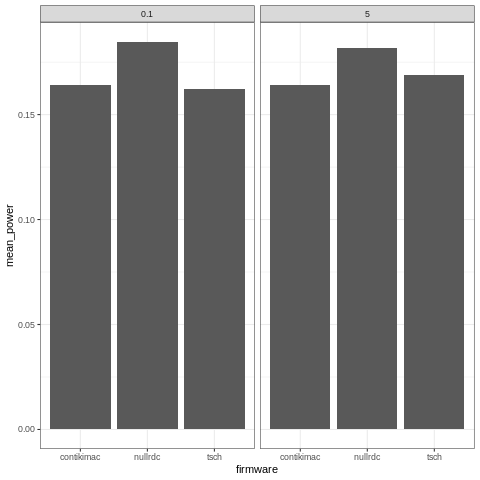

In [3]:
%%R -i out
library(ggplot2)
library(dplyr)

out %>% group_by(firmware, sleep_interval) %>% summarize(mean_power = mean(power)) %>%
ggplot(aes(x=firmware, y=mean_power)) + geom_col() +
    facet_wrap(~sleep_interval) + theme_bw()

#### Voltage

`summarise()` has grouped output by 'firmware'. You can override using the `.groups` argument.


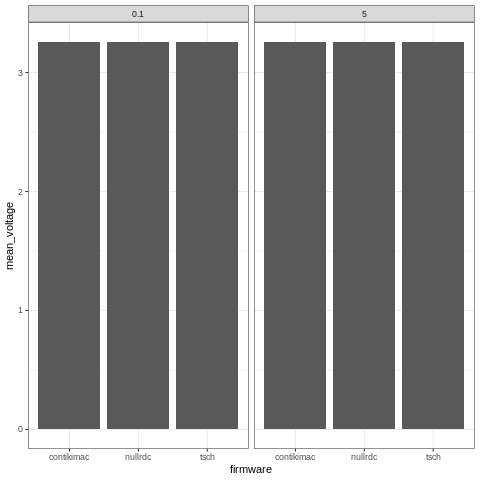

In [4]:
%%R -i out

out %>% group_by(firmware, sleep_interval) %>% summarize(mean_voltage = mean(voltage)) %>%
ggplot(aes(x=firmware, y=mean_voltage)) + geom_col() +
    facet_wrap(~sleep_interval) + theme_bw()

#### Current

`summarise()` has grouped output by 'firmware'. You can override using the `.groups` argument.


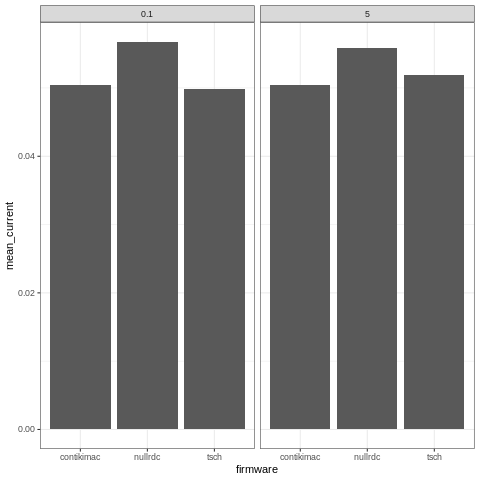

In [5]:
%%R -i out

out %>% group_by(firmware, sleep_interval) %>% summarize(mean_current = mean(current)) %>%
ggplot(aes(x=firmware, y=mean_current)) + geom_col() +
    facet_wrap(~sleep_interval) + theme_bw()

### Response time

In [6]:
%load_ext rpy2.ipython
import pandas

out = pandas.read_csv("%s/elapsed_results.csv" % cur_dir)
out

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Unnamed: 0     timestamp     n                      node  ok   elapsed  \
0               0  1.631004e+09     0  2001:660:5307:3130::a172   1  0.162220   
1               1  1.631004e+09     1  2001:660:5307:3130::a172   1  0.439956   
2               2  1.631004e+09     2  2001:660:5307:3130::a172   1  0.170627   
3               3  1.631004e+09     3  2001:660:5307:3130::a172   1  0.169606   
4               4  1.631004e+09     4  2001:660:5307:3130::a172   1  0.229662   
...           ...           ...   ...                       ...  ..       ...   
10976        2939  1.631007e+09  1099  2001:660:5307:3130::a172   1  0.085958   
10977        2940  1.631007e+09  1100  2001:660:5307:3130::a172   1  0.166596   
10978        2941  1.631007e+09  1101  2001:660:5307:3130::a172   1  0.229685   
10979        2942  1.631007e+09  1102  2001:660:5307:3130::a172   1  0.284921   
10980        2943  1.631007e+09  1103  2001:660:5307:3130::a172   1  0.134609   

                                     exp_id  sleep_interval    firmware  
0      fe58d6fe-7a62-4424-ba3f-ed16aae2fac3             0.1        tsch  
1      fe58d6fe-7a62-4424-ba3f-ed16aae2fac3             0.1        tsch  
2      fe58d6fe-7a62-4424-ba3f-ed16aae2fac3             0.1        tsch  
3      fe58d6fe-7a62-4424-ba3f-ed16aae2fac3             0.1        tsch  
4      fe58d6fe-7a62-4424-ba3f-ed16aae2fac3             0.1        tsch  
...                                     ...             ...         ...  
10976  c026cf79-c26c-44d1-ac38-75d715b8634f             0.1  contikimac  
10977  c026cf79-c26c-44d1-ac38-75d715b8634f             0.1  contikimac  
10978  c026cf79-c26c-44d1-ac38-75d715b8634f             0.1  contikimac  
10979  c026cf79-c26c-44d1-ac38-75d715b8634f             0.1  contikimac  
10980  c026cf79-c26c-44d1-ac38-75d715b8634f             0.1  contikimac  

[10981 rows x 9 columns]

#### Response time ($R$) against $\lambda$ (theoretical)

Observed $\lambda$: count number of requests done and divide by experiment duration (300s).

`summarise()` has grouped output by 'firmware'. You can override using the `.groups` argument.


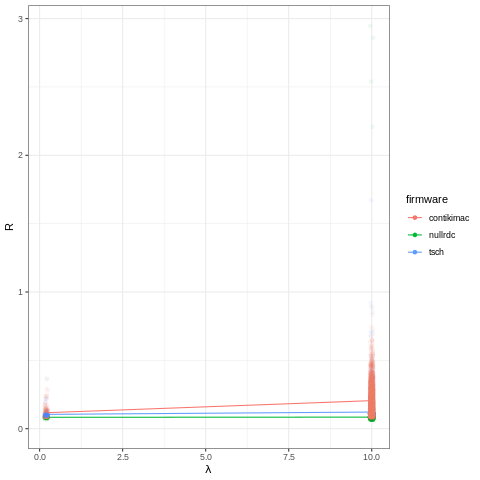

In [7]:
%%R -i out

out %>% group_by(firmware,sleep_interval) %>% summarize(mean_elapsed = mean(elapsed)) %>%
ggplot(aes(1/sleep_interval, mean_elapsed, color=firmware)) + geom_point() + geom_line() +
    geom_jitter(data=out, aes(1/sleep_interval, elapsed), alpha=.05, width=.05) + 
    ylab(expression("R")) + ylim(0, NA) + xlab(expression(lambda)) + theme_bw()

We have a few outliers, let cut them off to see.

Also plot each firmware individually to see the details.

`summarise()` has grouped output by 'firmware'. You can override using the `.groups` argument.


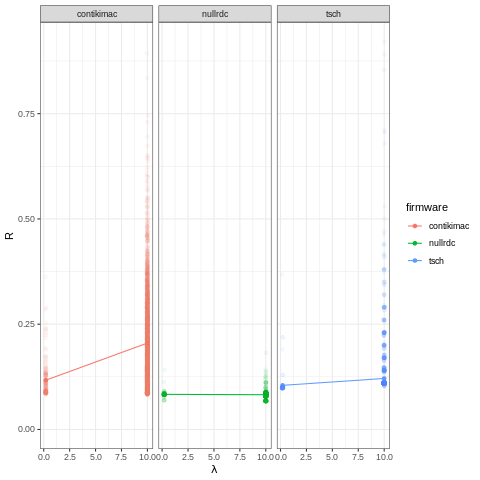

In [8]:
%%R -i out
out = out %>% filter(elapsed < 1)
out %>% group_by(firmware,sleep_interval) %>% summarize(mean_elapsed = mean(elapsed)) %>%
ggplot(aes(1/sleep_interval, mean_elapsed, color=firmware)) + geom_point() + geom_line() +
    geom_jitter(data=out, aes(1/sleep_interval, elapsed), alpha=.05, width=.05) + 
    ylab(expression("R")) + ylim(0, NA) + xlab(expression(lambda)) + theme_bw() + facet_wrap(~firmware)

#### Response time ($R$) against $\lambda$ (observed)

Observed $\lambda$: count number of requests done and divide by experiment duration (300s).

`summarise()` has grouped output by 'firmware'. You can override using the `.groups` argument.


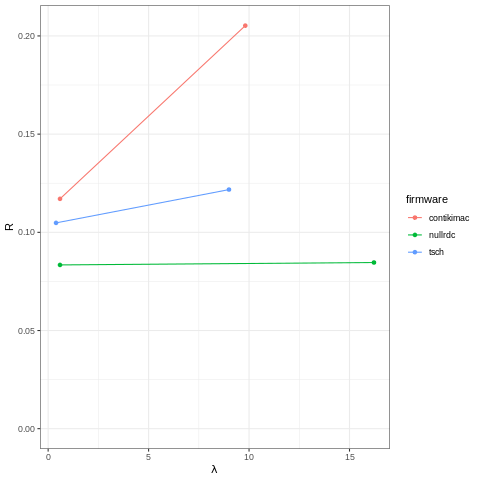

In [9]:
%%R -i out

out %>% group_by(firmware,sleep_interval) %>% summarize(lambda=mean(n()/300), mean_elapsed = mean(elapsed)) %>%
ggplot(aes(lambda, mean_elapsed, color=firmware)) + geom_point() + geom_line() +
    ylab(expression("R")) + ylim(0, NA) + xlab(expression(lambda)) + theme_bw()